# 5. Hypothesis Testing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import mysql.connector
import datetime
import math
from scipy import stats

In [2]:
username = 'root'
user_password = 'Sadegh74'

In [3]:
cnx = mysql.connector.connect(
    user=username,
    password=user_password,
    host='localhost',
    database='test_project'
)

### 5.1. Players'Performance at the First Season in Each Team

In [4]:
q_h1 = "SELECT * FROM transfers AS t JOIN players_season ps on ps.player_id = t.player_id AND t.season_id = ps.season_id JOIN players p on t.player_id = p.id JOIN seasons s on t.season_id = s.id WHERE start_date BETWEEN 2017 AND 2021;"
H1 = pd.read_sql(q_h1, con=cnx)
H1.head()

,Id,player_id,origin_club_id,destination_club_id,season_id,market_value,fee,id,player_id,season_id,...,birth_place,citizenship,position,national_id,current_value,agent,foot,id,start_date,end_date
0,1,2,1,3,1,50000,23000,2,2,1,...,None,None,Centre-Back,2,62513.0,ZTUHS,right,1,2021,2022
1,2,9,2,1,1,77000,23000,9,9,1,...,None,None,Centre-Back,3,70513.0,JZMWC,left,1,2021,2022
2,3,18,3,2,1,35000,87000,18,18,1,...,None,None,Centre-Back,2,64512.0,CJRHE,right,1,2021,2022


In [5]:
H1['PPI'] = 0

for index, row in H1.iterrows():
    position = row['position']
    minutes_played = row['minutes_played']
    goals = row['goals']
    assists = row['assists']
    clean_sheets = row['clean_sheets']
    goals_conceded = row['goals_conceded']
    
    if position == 'Goalkeeper':
        H1.at[index, 'PPI'] = clean_sheets * 10 + goals_conceded * (-5) + (minutes_played / 90) * 2
    elif position == 'Defender':
        H1.at[index, 'PPI'] = clean_sheets * 5 + goals * 6 + assists * 3 + (minutes_played / 90) * 2
    elif position == 'Midfielder':
        H1.at[index, 'PPI'] = goals * 5 + assists * 7 + (minutes_played / 90) * 2
    elif position == 'Forward':
        H1.at[index, 'PPI'] = goals * 8 + assists * 5 + (minutes_played / 90) * 2

H1

,Id,player_id,origin_club_id,destination_club_id,season_id,market_value,fee,id,player_id,season_id,...,citizenship,position,national_id,current_value,agent,foot,id,start_date,end_date,PPI
0,1,2,1,3,1,50000,23000,2,2,1,...,None,Centre-Back,2,62513.0,ZTUHS,right,1,2021,2022,0
1,2,9,2,1,1,77000,23000,9,9,1,...,None,Centre-Back,3,70513.0,JZMWC,left,1,2021,2022,0
2,3,18,3,2,1,35000,87000,18,18,1,...,None,Centre-Back,2,64512.0,CJRHE,right,1,2021,2022,0


In [6]:
current_year = datetime.date.today().year
H1['Historical_Age'] = H1['age'] - H1['start_date'].apply(lambda x: current_year - x)
H1_young = H1[H1['Historical_Age'] <= 30]
H1_old = H1[H1['Historical_Age'] > 30]

In [7]:
ppi_younger = H1_young['PPI'].values
ppi_older = H1_old['PPI'].values

t_statistic, p_value = stats.ttest_ind(ppi_younger, ppi_older)

alpha = 0.05

if p_value < alpha:
    print("Reject the null hypothesis. There is evidence that players older than 30 have better performance than players younger than 30.")
else:
    print("Fail to reject the null hypothesis. There is no significant evidence to conclude that players older than 30 have better performance than players younger than 30.")

Fail to reject the null hypothesis. There is no significant evidence to conclude that players older than 30 have better performance than players younger than 30.


c:\Users\battlebox\anaconda3\envs\quera\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\battlebox\anaconda3\envs\quera\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


### 5.3. Active Players vs Age

In [8]:
'''top_leagues = ['Premier League', 'La Liga', 'Bundesliga', 'Serie A', 'Ligue 1']
top_leagues_str = ','.join(map(str, top_leagues))
q_h3 = f"SELECT c.name, cs.players_avg_age, count((appearance/cs.matches)>= 0.2) AS active_players FROM players_season AS ps JOIN clubs_season cs on ps.club_id = cs.club_id AND cs.season_id = ps.season_id JOIN seasons s on ps.season_id = s.id JOIN competitions c2 on cs.competition_id = c2.id JOIN clubs c on ps.club_id = c.id WHERE start_date = 2021 AND c2.name IN ({top_leagues_str}) GROUP BY cs.id ORDER BY active_players desc;"'''

q_h3 = f"SELECT c.name, cs.players_avg_age, count((appearance/cs.matches)>= 0.2) AS active_players FROM players_season AS ps JOIN clubs_season cs on ps.club_id = cs.club_id AND cs.season_id = ps.season_id JOIN seasons s on ps.season_id = s.id JOIN competitions c2 on cs.competition_id = c2.id JOIN clubs c on ps.club_id = c.id WHERE start_date = 2021 AND c2.name IN ('league 1 ','league 2') GROUP BY cs.id ORDER BY active_players desc;"

H3 = pd.read_sql(q_h3, con=cnx)
H3.head()

,name,players_avg_age,active_players
0,club3,26,8
1,club4,27,7


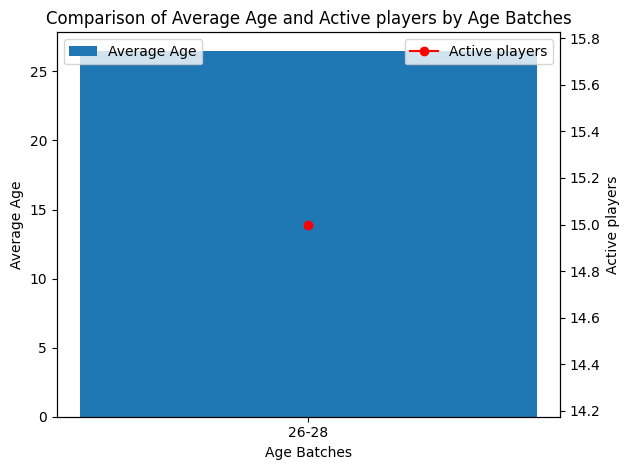

In [9]:
import numpy as np
import matplotlib.pyplot as plt

min_age = H3['players_avg_age'].min()
max_age = H3['players_avg_age'].max()

num_batches = int((max_age - min_age) / 2) + 1
batch_range = np.arange(min_age, max_age + 2, 2)

# Create empty lists to store the average ages and active players for each batch
avg_age_data = []
active_players_data = []

# Iterate through each batch and calculate the average age and active players
for i in range(num_batches):
    lower_bound = batch_range[i]
    upper_bound = batch_range[i+1]
    batch_data = H3[(H3['players_avg_age'] >= lower_bound) & (H3['players_avg_age'] < upper_bound)]
    
    avg_age = batch_data['players_avg_age'].mean()
    active_players = batch_data['active_players'].sum()
    
    avg_age_data.append(avg_age)
    active_players_data.append(active_players)


x = np.arange(num_batches)
width = 0.35

fig, ax1 = plt.subplots()

ax1.bar(x, avg_age_data, width, label='Average Age')
ax1.set_xlabel('Age Batches')
ax1.set_ylabel('Average Age')
ax1.set_xticks(x)
ax1.set_xticklabels([f'{int(batch_range[i])}-{int(batch_range[i+1])}' for i in range(num_batches)])
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(x, active_players_data, color='red', marker='o', label='Active players')
ax2.set_ylabel('Active players')
ax2.legend(loc='upper right')

plt.title('Comparison of Average Age and Active players by Age Batches')
plt.tight_layout()
plt.show()
